Libs

In [42]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Load the dataset

In [43]:
df_adj = pd.read_csv('dataset/consensus_adj_mat.csv')
df_adj 

,Unnamed: 0,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,Akt,0,0,0,0,0,0,0,0,0,0,0
1,Erk,0,0,0,0,0,0,0,0,0,0,0
2,Jnk,0,0,0,0,0,0,0,0,0,0,0
3,Mek,0,1,0,0,0,0,0,0,0,0,0
4,P38,0,0,0,0,0,0,0,0,0,0,0
5,PIP2,0,0,0,0,0,0,0,0,1,0,0
6,PIP3,1,0,0,0,0,1,0,0,0,1,0
7,PKA,1,1,1,1,1,0,0,0,0,0,1
8,PKC,0,0,1,1,1,0,0,0,0,0,1
9,Plcg,0,0,0,0,0,1,0,0,1,0,0


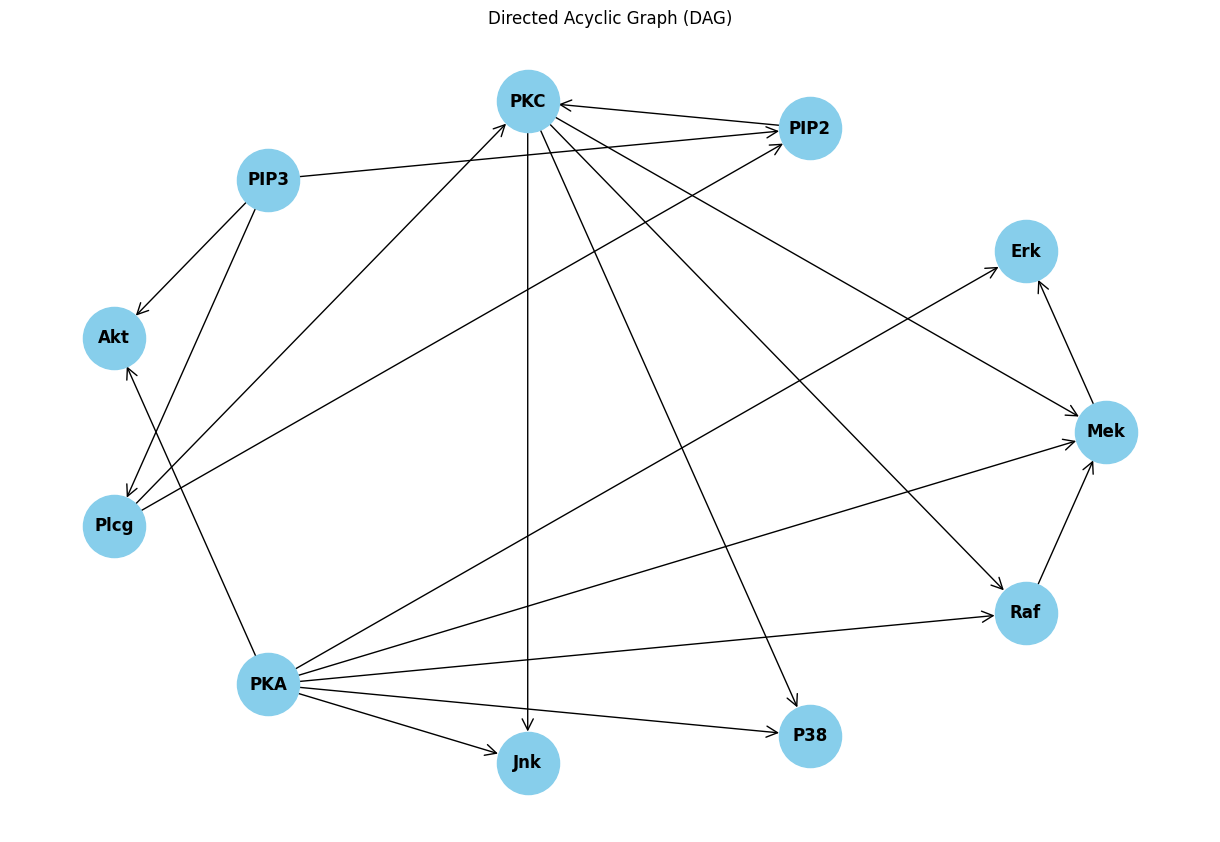

In [44]:
# Initialize a directed graph
G = nx.DiGraph()

# Rename the unnamed column for clarity
df_adj = df_adj.rename(columns={"Unnamed: 0": "Node"})

# Add edges based on the dataframe
for index, row in df_adj.iterrows():
    for col in df_adj.columns[1:]:
        if row[col] == 1:
            G.add_edge(row["Node"], col)

# Use a layout algorithm to position the nodes
pos = nx.circular_layout(G)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=12, font_weight="bold", arrowstyle="->", arrowsize=20)
plt.title("Directed Acyclic Graph (DAG)")
plt.show()

In [45]:
print("Nodes: ", G.nodes)
print("Edges: ", G.edges)

Nodes:  ['Mek', 'Erk', 'PIP2', 'PKC', 'PIP3', 'Akt', 'Plcg', 'PKA', 'Jnk', 'P38', 'Raf']
Edges:  [('Mek', 'Erk'), ('PIP2', 'PKC'), ('PKC', 'Jnk'), ('PKC', 'Mek'), ('PKC', 'P38'), ('PKC', 'Raf'), ('PIP3', 'Akt'), ('PIP3', 'PIP2'), ('PIP3', 'Plcg'), ('Plcg', 'PIP2'), ('Plcg', 'PKC'), ('PKA', 'Akt'), ('PKA', 'Erk'), ('PKA', 'Jnk'), ('PKA', 'Mek'), ('PKA', 'P38'), ('PKA', 'Raf'), ('Raf', 'Mek')]


sachs_bin

In [46]:
df_bin = pd.read_csv('dataset/sachs_bin.csv')
df_bin = df_bin.astype(int)
df_bin

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC
0,0,0,1,0,1,0,1,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
848,0,0,0,0,0,0,0,0,1
849,0,0,1,0,1,0,1,0,0
850,0,0,0,1,0,0,1,0,0
851,0,0,0,0,1,0,1,0,1


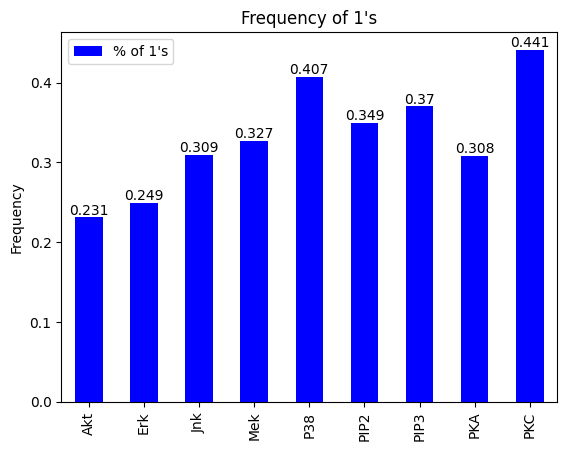

In [114]:
# Calculate the frequency of 1's and 0's for each column
# freq_1 = df_bin.apply(lambda x: x.value_counts().get(1, 0))
freq_1 = np.round(df_bin.mean(), 3)

# Plot the frequency for all rows
fig, ax = plt.subplots()
freq_1.plot(kind='bar', ax=ax, label="% of 1's", color='blue')

for bars in ax.containers:
    ax.bar_label(bars)

plt.ylabel('Frequency')
plt.title('Frequency of 1\'s')
plt.legend()
plt.show()

Forward simulation

In [87]:
def simulate_binomial(alpha):
    #pip3, pka
    X7, X8 = np.random.binomial(n=1, p=alpha), np.random.binomial(n=1, p=alpha)
    # print("PIP3: X7 = ", X7, " with probability", alpha)
    # print("PKA: X8 = ", X8, " with probability", alpha)
    
    ### akt <- pip3, pka
    p_X1 = 1 - alpha ** (1+X7+X8) 
    X1 = np.random.binomial(n=1, p=p_X1)
    # print("Akt: X1 = ", X1," with probability", p_X1)

    ### plcg <- pip3
    p_X10 = 1 - alpha ** (1+X7)
    X10 = np.random.binomial(n=1, p=p_X10)
    # print("Plcg: X10 = ", X10," with probability", p_X10)

    ### pip2 <- pip3, plcg
    p_X6 = 1 - alpha ** (1+X7+X10)
    X6 = np.random.binomial(n=1, p=p_X6)
    # print("PIP2: X6 = ", X6," with probability", p_X6)
    
    ### pkc <- plcg, pip2
    p_X9 = 1 - alpha ** (1+X10+X6)
    X9 = np.random.binomial(n=1, p=p_X9)
    # print("PKC: X9 = ", X9," with probability", p_X9)

    ### jnk <- pkc, pka
    p_X3 = 1 - alpha ** (1+X9+X8)
    X3 = np.random.binomial(n=1, p=p_X3)
    # print("Jnk: X3 = ", X3," with probability", p_X3)

    ### p38 <- pkc, pka
    p_X5 = 1 - alpha ** (1+X9+X8)
    X5 = np.random.binomial(n=1, p=p_X5)
    # print("P38: X5 = ", X5," with probability", p_X5)

    ### raf <- pkc, pka
    p_X11 = 1 - alpha ** (1+X9+X8)
    X11 = np.random.binomial(n=1, p=p_X11)
    # print("Raf: X11 = ", X11," with probability", p_X11)

    ### mek <- raf, pka, pkc
    p_X4 = 1 - alpha ** (1+X11+X8+X9)
    X4 = np.random.binomial(n=1, p=p_X4)
    # print("Mek: X4 = ", X4," with probability", p_X4)

    ### erk <- mek, pka
    p_X2 = 1 - alpha ** (1+X4+X8)
    X2 = np.random.binomial(n=1, p=p_X2)
    # print("Erk: X2 = ", X2," with probability", p_X2)

    return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]

simulate_binomial(0.5)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]

Simulation

In [88]:
def forward(alpha, n):
    lst = []
    for elm in range(0, n):
        lst.append(simulate_binomial(alpha))
    df_adj=pd.DataFrame(lst,columns=['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11'])
    return(df_adj)

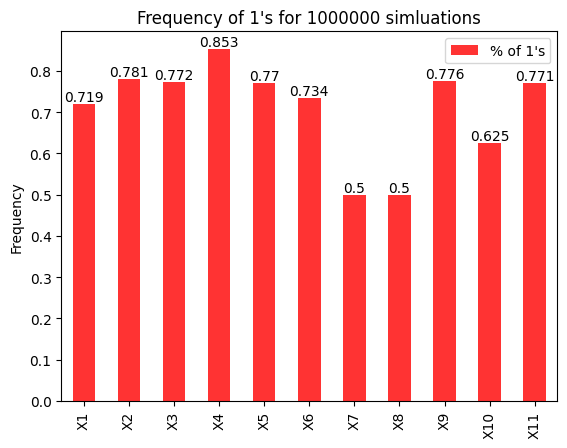

In [112]:
# Simulation size
n = 1000000 
# Calculate the frequency of 1's and 0's for each column
# for_freq_1 = forward(0.5, 1000).apply(lambda x: x.value_counts().get(1, 0))
for_freq_1 = np.round(forward(0.5, n).mean(), 3) 

# Plot the frequency for all rows
fig, ax = plt.subplots()
for_freq_1.plot(kind='bar', ax=ax, label="% of 1's", color='red', alpha=0.8)

for bars in ax.containers:
    ax.bar_label(bars)

plt.ylabel('Frequency')
plt.title(f'Frequency of 1\'s for {n} simluations')
plt.legend()
plt.show()

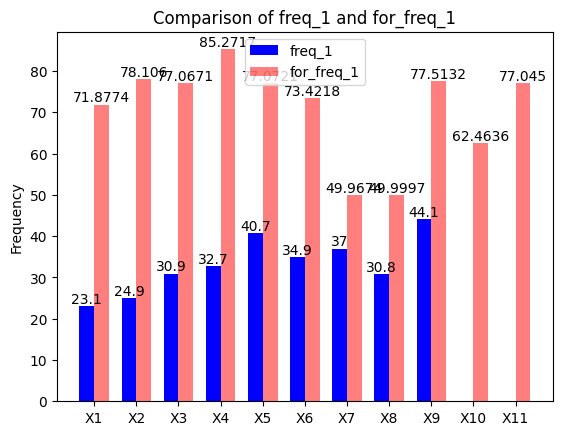

In [106]:
fig, ax = plt.subplots()

width = 0.35  # width of the bars

# Plot the freq_1 bars
ax.bar(np.arange(len(freq_1)), freq_1, width, label='freq_1', color='blue')

# Plot the for_freq_1 bars next to freq_1 bars
ax.bar(np.arange(len(for_freq_1)) + width, for_freq_1, width, label='for_freq_1', color='red', alpha=0.5)

for bars in ax.containers:
    ax.bar_label(bars)

ax.set_ylabel('Frequency')
ax.set_title('Comparison of freq_1 and for_freq_1')
ax.set_xticks(np.arange(len(for_freq_1)) + width / 2)
ax.set_xticklabels(for_freq_1.index)
ax.legend()

plt.show()